# Intro  
L'ensemble de données FD003 est le troisième de la série.

Trajectoires d'entraînement : 100

Trajectoires de test : 100

Conditions : UNE (Niveau de la mer)

Modes de défaillance : DEUX (Dégradation HPC, Dégradation du ventilateur)

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Commençons par charger les données et démarrer notre Analyse Exploratoire des Données (EDA) en inspectant les premières lignes, afin de nous familiariser avec la structure des données.


In [ ]:
# define filepath to read data
dir_path = './CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD003.txt'), sep='\s+', header=None, names=col_names)
x_test = pd.read_csv((dir_path+'test_FD003.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD003.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0005     0.0004      100.0  518.67  642.36   
1        1            2     0.0008    -0.0003      100.0  518.67  642.50   
2        1            3    -0.0014    -0.0002      100.0  518.67  642.18   
3        1            4    -0.0020     0.0001      100.0  518.67  642.92   
4        1            5     0.0016     0.0000      100.0  518.67  641.68   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246  0.03   391   
1  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403  0.03   392   
2  1582.35  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901  0.03   391   
3  1585.61  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878  0.03   392   
4  1588.63  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869  0.03   392   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.11  23.3537  
1  2388  100.0  38.99  23.4491  
2  2388  100.0  38.85  23.3669  
3  2388  100.0  38.96  23.2951  
4  2388  100.0  39.14  23.4583  

[5 rows x 26 columns]

In [ ]:
#Supprimer toutes les lignes supplémentaires et conserver uniquement le dernier cycle de chaque moteur.
x_test=x_test.groupby('unit_nr').last().reset_index()
x_test.shape

(100, 26)

In [ ]:
# Imputer les NAN avec la moyenne
train.fillna(train.mean(), inplace=True)
x_test.fillna(x_test.mean(), inplace=True)
y_test.fillna(y_test.mean(), inplace=True)


##Checking for missing values:

In [ ]:
def check_missing_values(data):
    print('Verifing the existance of null data:')
    return data.isnull().sum()

print(check_missing_values(train))

Verifing the existance of null data:
unit_nr        0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


## Descriptive statistics

In [ ]:
# inspect unit_nr
train[index_names].describe()

unit_nr   time_cycles
count  24720.000000  24720.000000
mean      48.631877    139.077063
std       29.348985     98.846675
min        1.000000      1.000000
25%       23.000000     62.000000
50%       47.000000    124.000000
75%       74.000000    191.000000
max      100.000000    525.000000

In [ ]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

time_cycles
count    100.00000
mean     247.20000
std       86.48384
min      145.00000
25%      189.75000
50%      220.50000
75%      279.75000
max      525.00000

In [ ]:
# inspect settings
train[setting_names].describe()

setting_1     setting_2  setting_3
count  24720.000000  24720.000000    24720.0
mean      -0.000024      0.000005      100.0
std        0.002194      0.000294        0.0
min       -0.008600     -0.000600      100.0
25%       -0.001500     -0.000200      100.0
50%       -0.000000     -0.000000      100.0
75%        0.001500      0.000300      100.0
max        0.008600      0.000700      100.0

In [ ]:
# inspect sensor values
train[sensor_names].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   24720.0   518.670000  6.684921e-11   518.6700   518.6700   518.6700   
s_2   24720.0   642.457858  5.230311e-01   640.8400   642.0800   642.4000   
s_3   24720.0  1588.079175  6.810418e+00  1564.3000  1583.2800  1587.5200   
s_4   24720.0  1404.471212  9.773178e+00  1377.0600  1397.1875  1402.9100   
s_5   24720.0    14.620000  3.602525e-12    14.6200    14.6200    14.6200   
s_6   24720.0    21.595841  1.811600e-02    21.4500    21.5800    21.6000   
s_7   24720.0   555.143808  3.437343e+00   549.6100   553.1100   554.0500   
s_8   24720.0  2388.071555  1.582849e-01  2386.9000  2388.0000  2388.0700   
s_9   24720.0  9064.110809  1.998029e+01  9017.9800  9051.9200  9060.0100   
s_10  24720.0     1.301232  3.484849e-03     1.2900     1.3000     1.3000   
s_11  24720.0    47.415707  3.000742e-01    46.6900    47.1900    47.3600   
s_12  24720.0   523.050873  3.255314e+00   517.7700   521.1500   521.9800   
s_13  24720.0  2388.071643  1.581207e-01  2386.9300  2388.0100  2388.0700   
s_14  24720.0  8144.202916  1.650412e+01  8099.6800  8134.5100  8141.2000   
s_15  24720.0     8.396176  6.051161e-02     8.1563     8.3606     8.3983   
s_16  24720.0     0.030000  1.750371e-14     0.0300     0.0300     0.0300   
s_17  24720.0   392.566545  1.761459e+00   388.0000   391.0000   392.0000   
s_18  24720.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  24720.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  24720.0    38.988552  2.488647e-01    38.1700    38.8300    38.9900   
s_21  24720.0    23.393024  1.492338e-01    22.8726    23.2962    23.3916   

            75%        max  
s_1    518.6700   518.6700  
s_2    642.7900   645.1100  
s_3   1592.4125  1615.3900  
s_4   1410.6000  1441.1600  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    556.0400   570.4900  
s_8   2388.1400  2388.6000  
s_9   9070.0925  9234.3500  
s_10     1.3000     1.3200  
s_11    47.6000    48.4400  
s_12   523.8400   537.4000  
s_13  2388.1400  2388.6100  
s_14  8149.2300  8290.5500  
s_15     8.4370     8.5705  
s_16     0.0300     0.0300  
s_17   394.0000   399.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    39.1400    39.8500  
s_21    23.4833    23.9505

In [ ]:
# before we start plotting the data, let's compute RUL

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  258
1        1            2  257
2        1            3  256
3        1            4  255
4        1            5  254

## Plotting

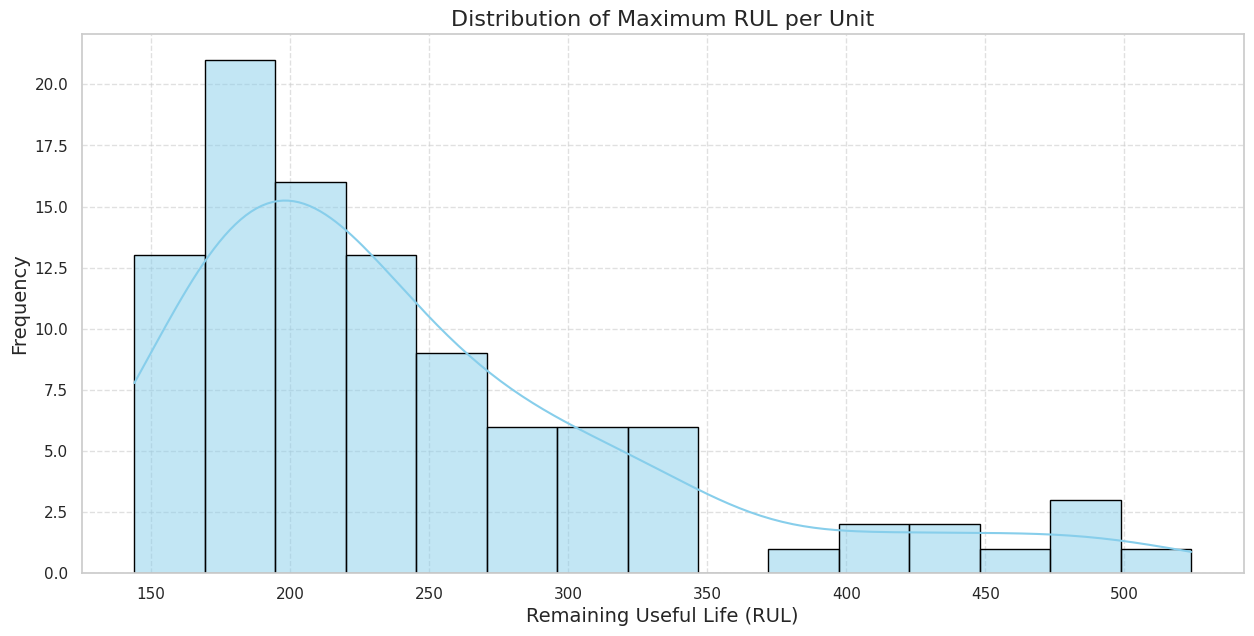

In [ ]:
#plotting
#faire des represetation graphique
# est important pour comprendre les districutions
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
# Configuration du style pour améliorer l'apparence
sns.set_theme(style="whitegrid")

# Histogramme avec des ajustements
plt.figure(figsize=(15, 7))
sns.histplot(df_max_rul['RUL'], bins=15, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Maximum RUL per Unit', fontsize=16)
plt.xlabel('Remaining Useful Life (RUL)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



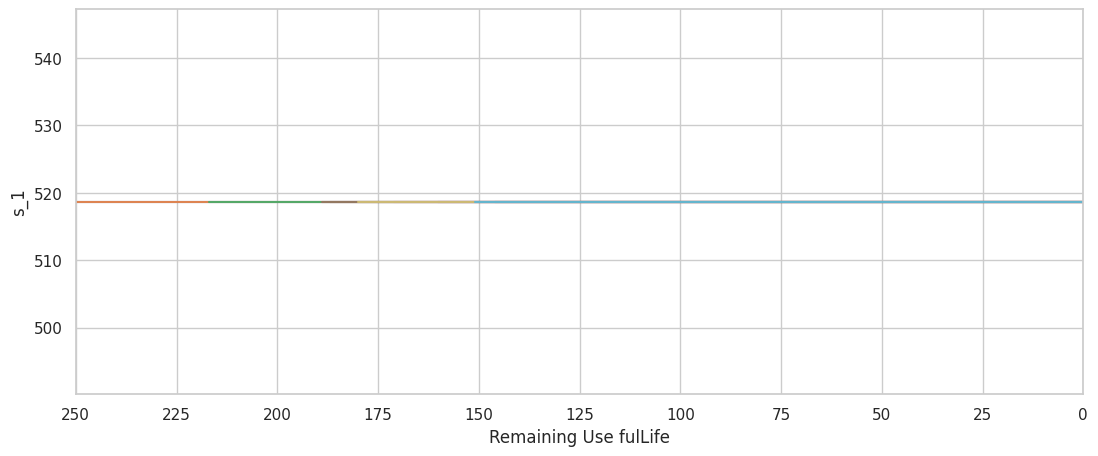

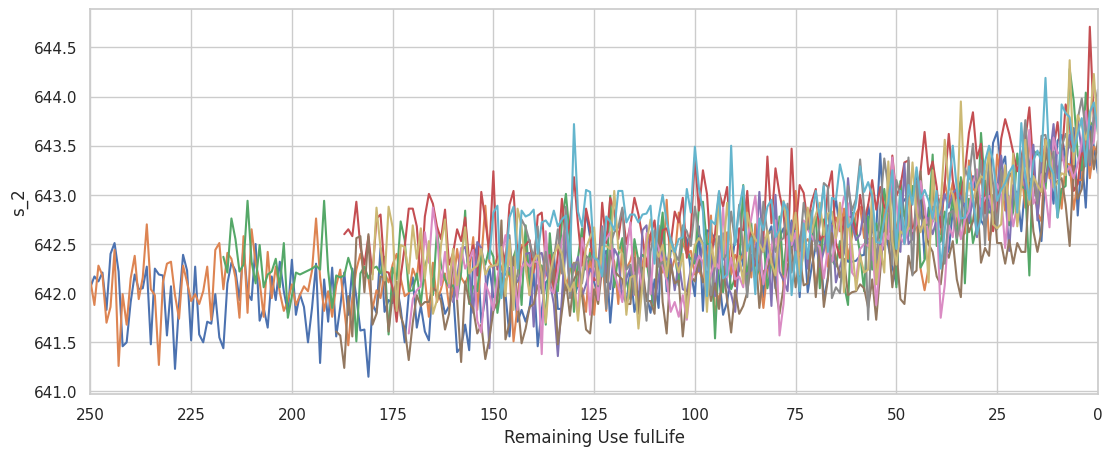

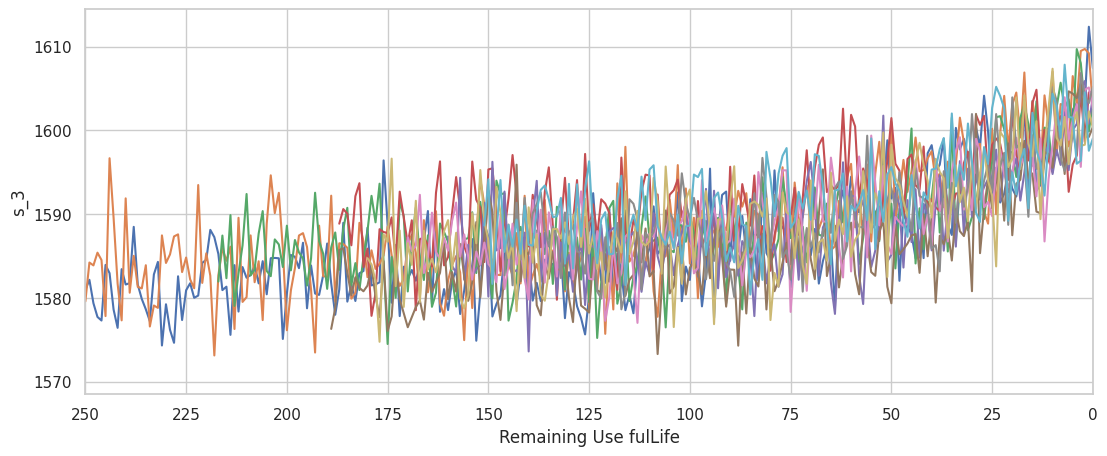

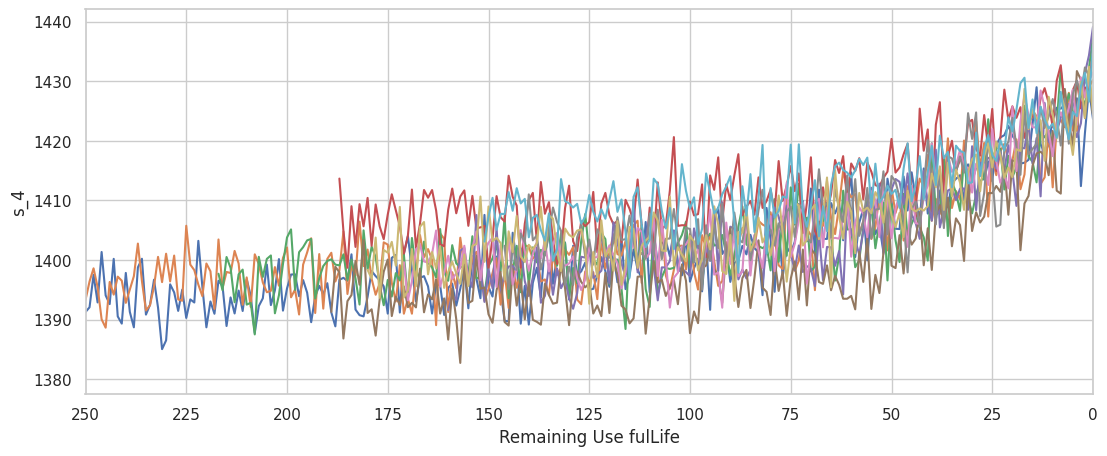

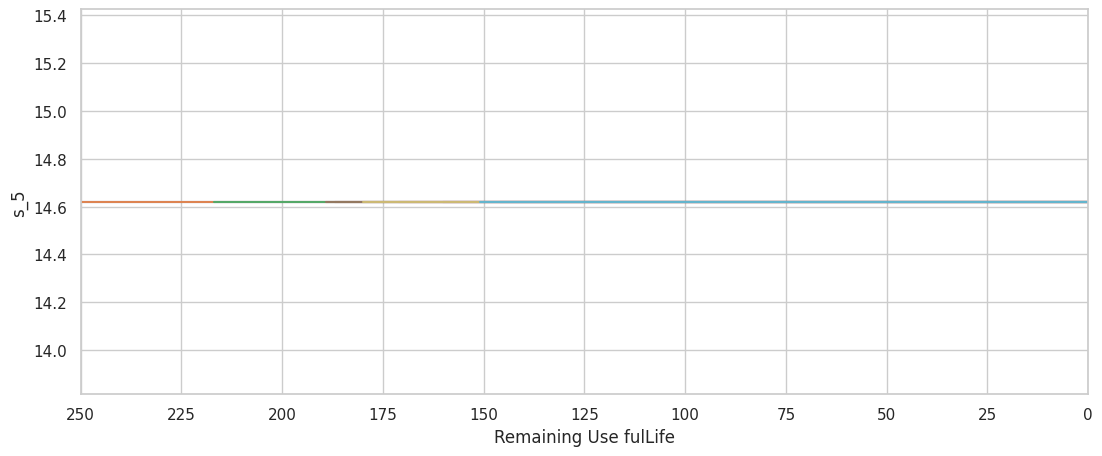

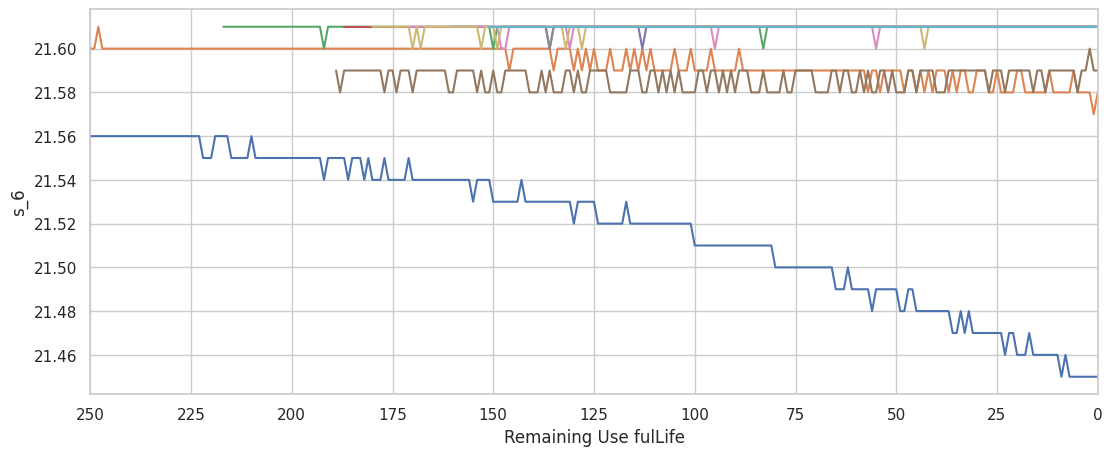

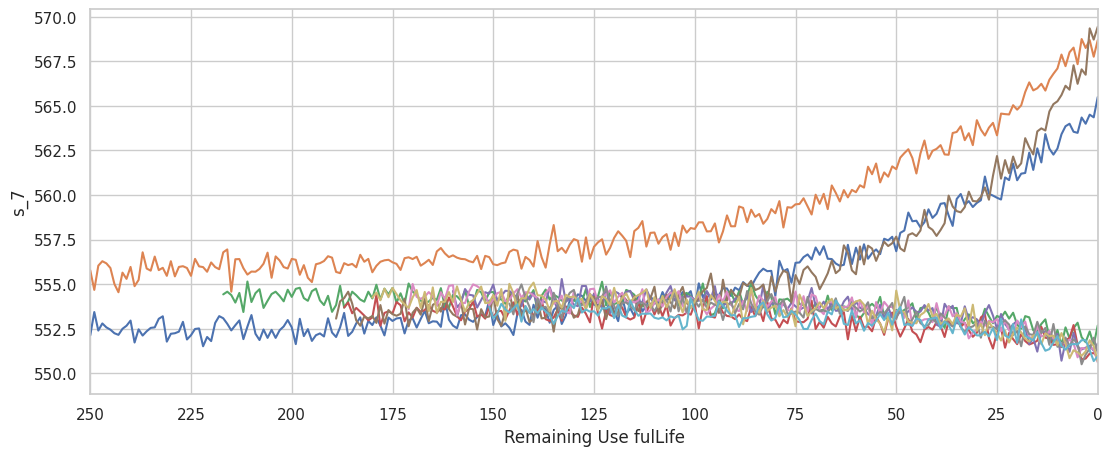

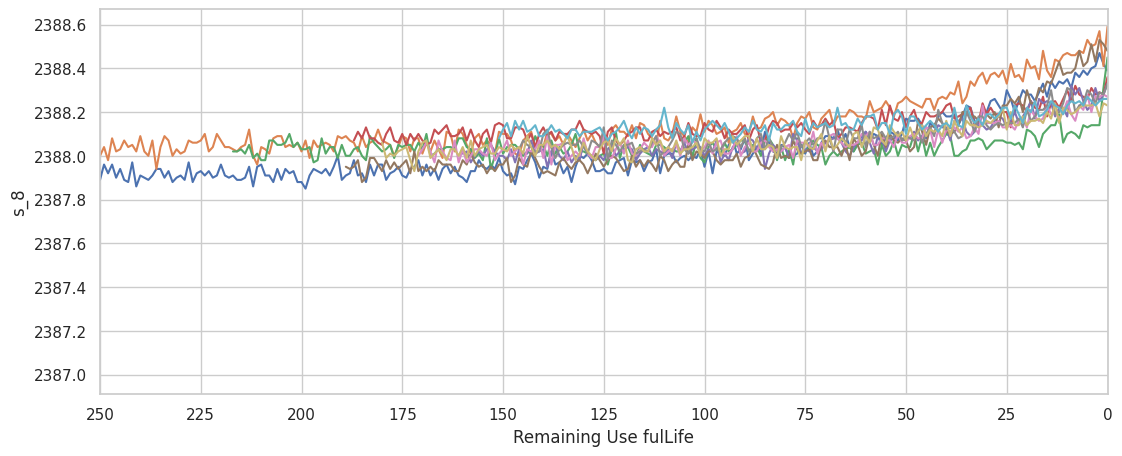

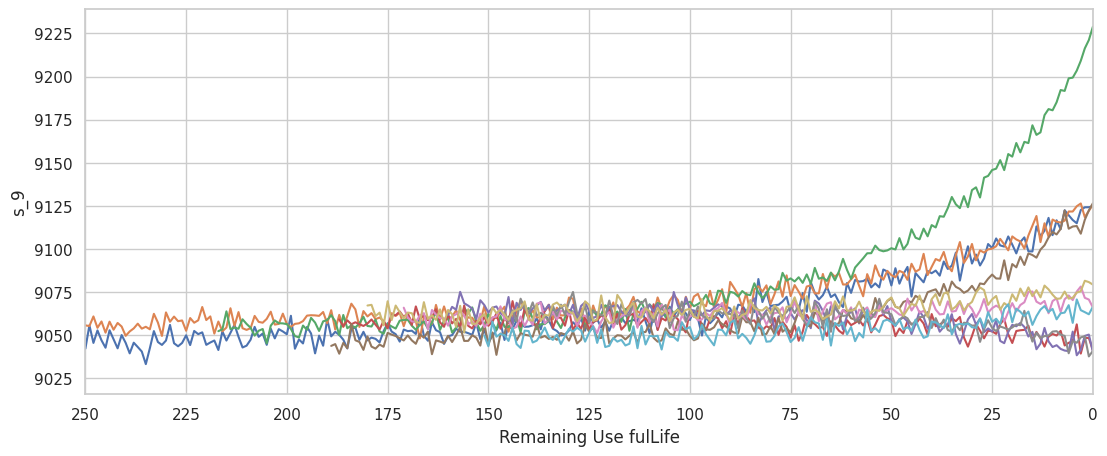

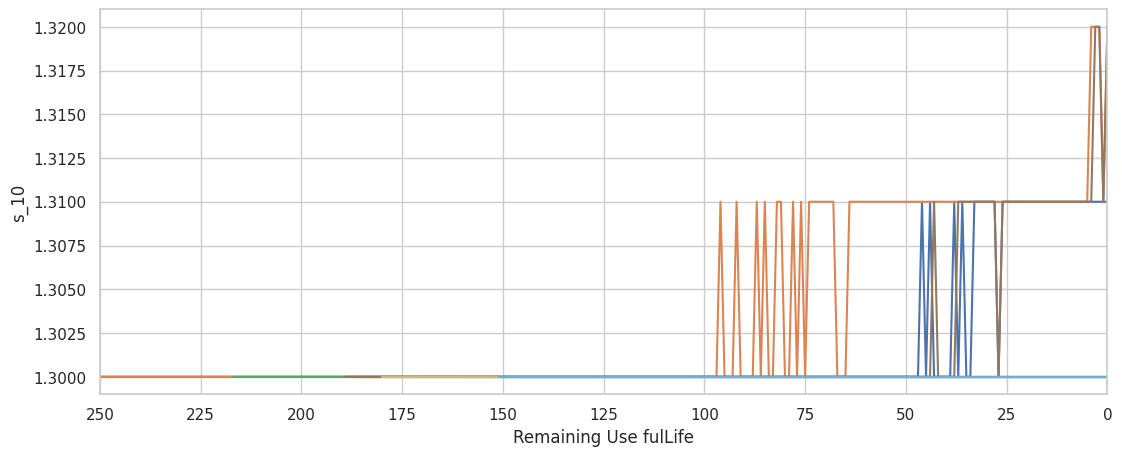

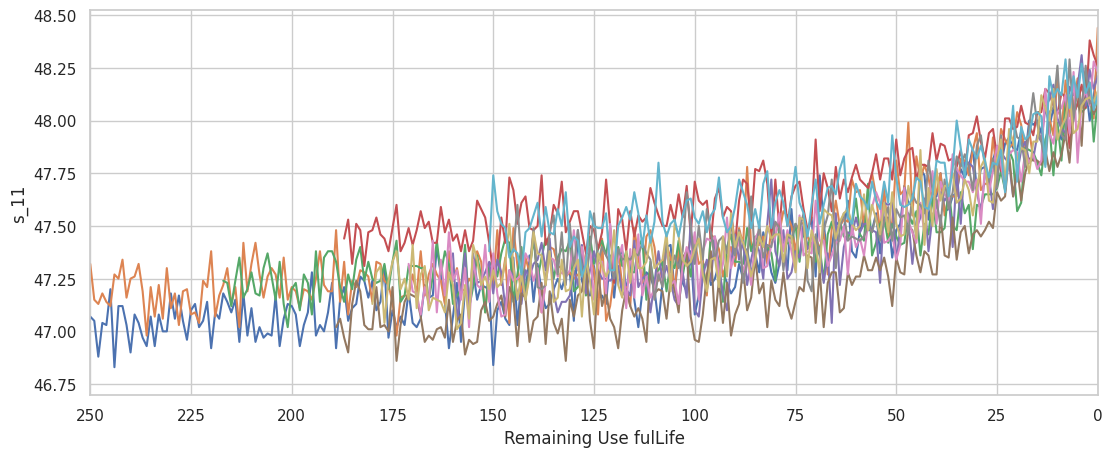

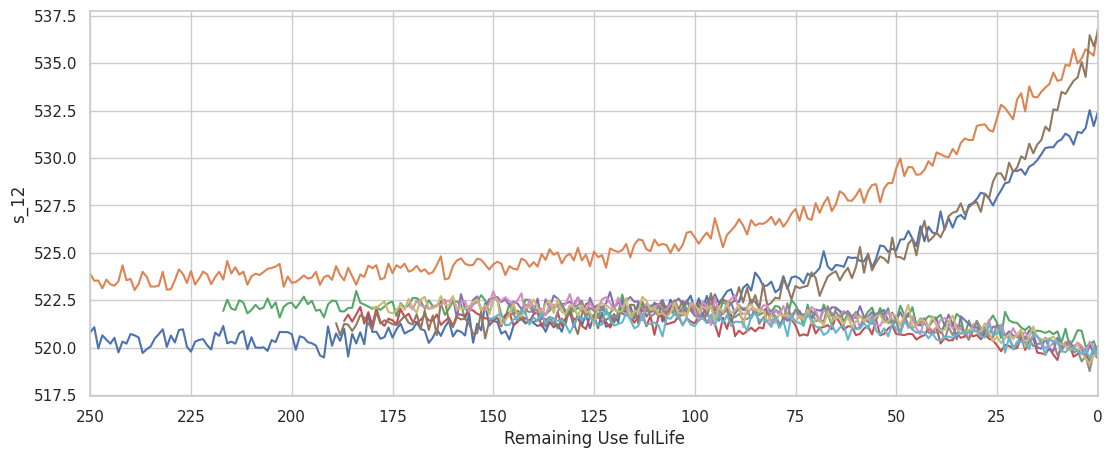

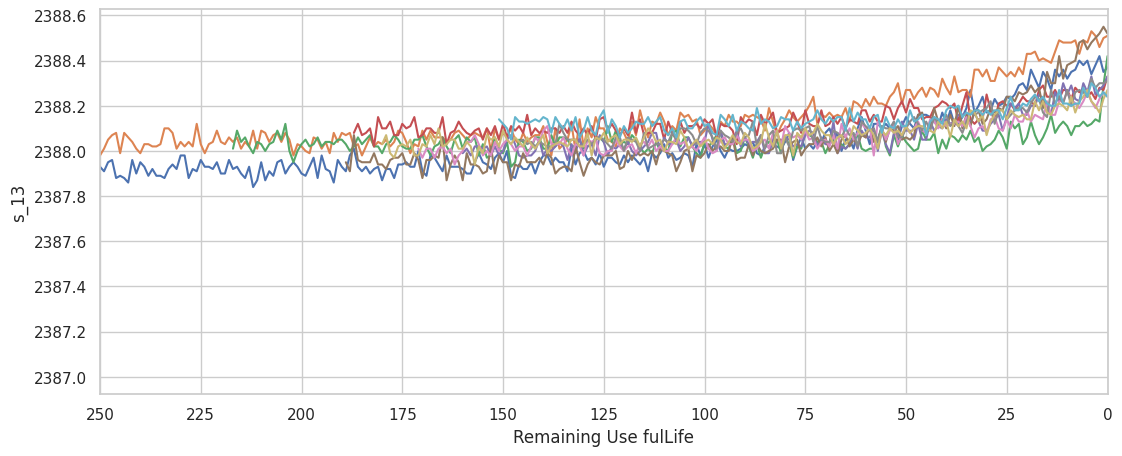

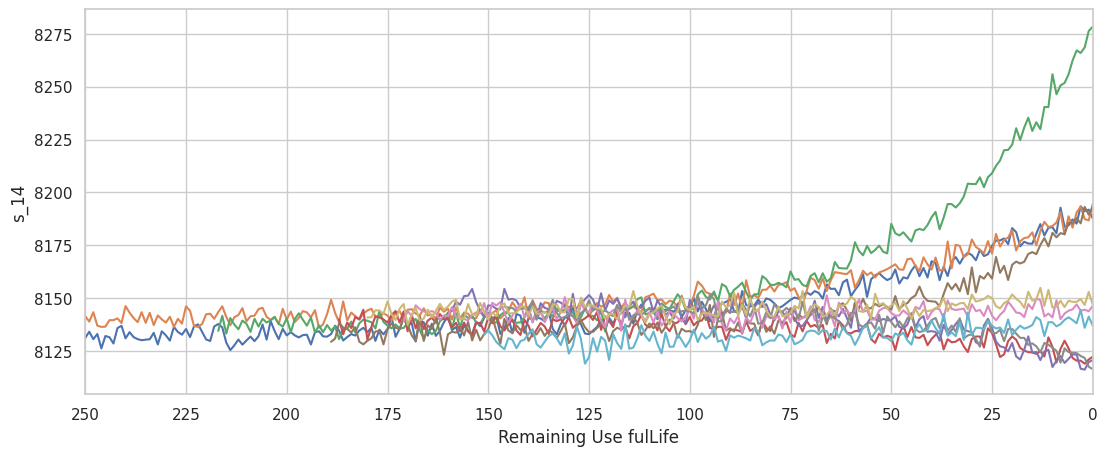

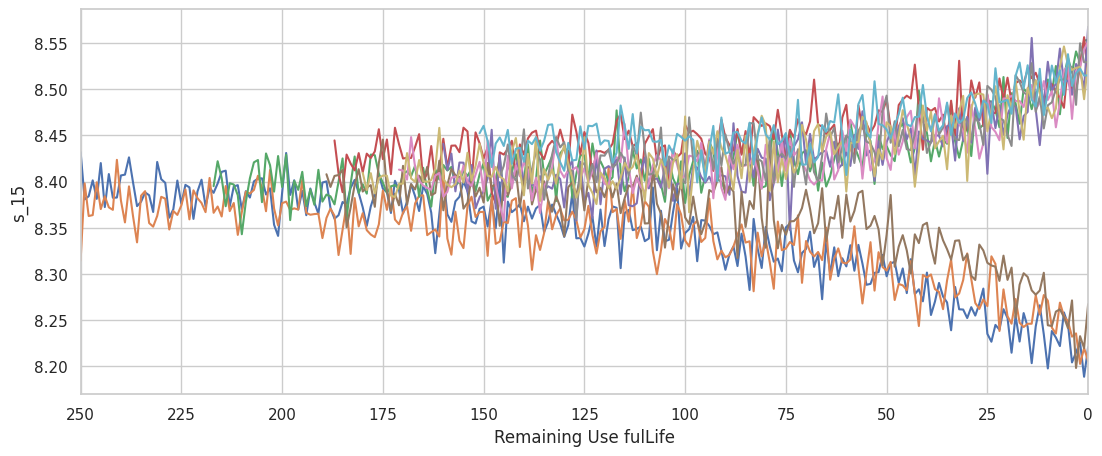

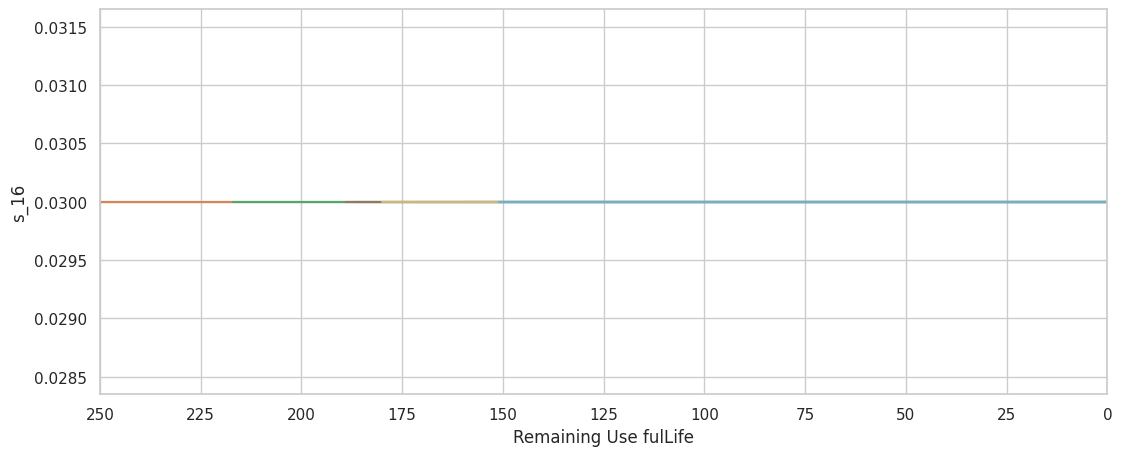

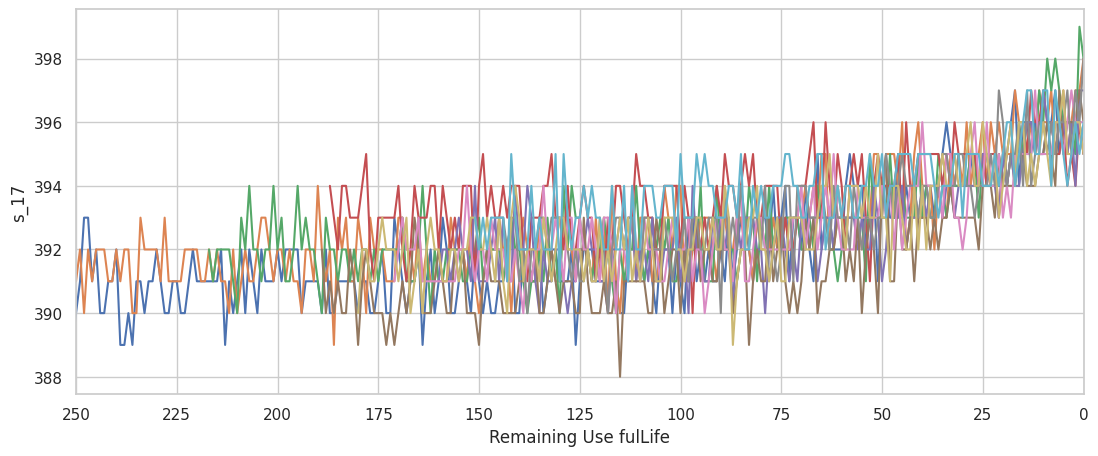

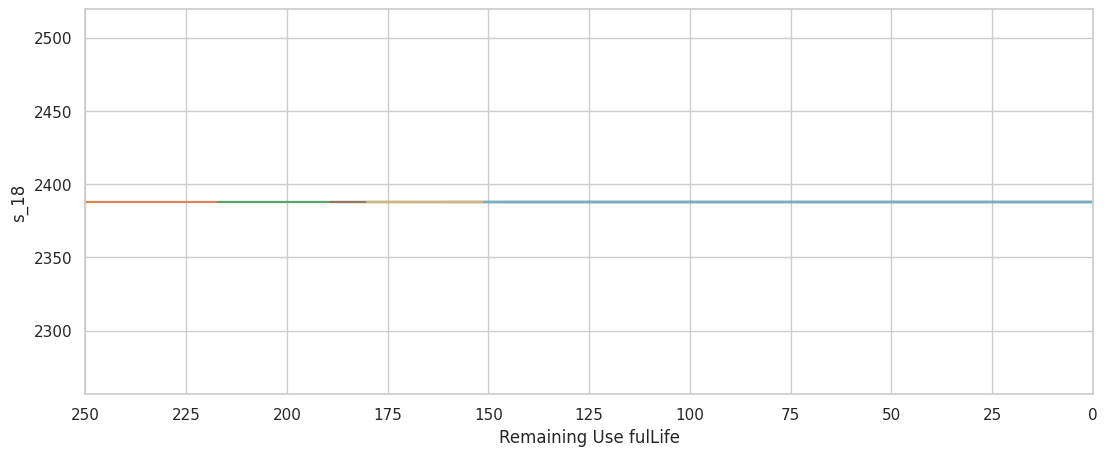

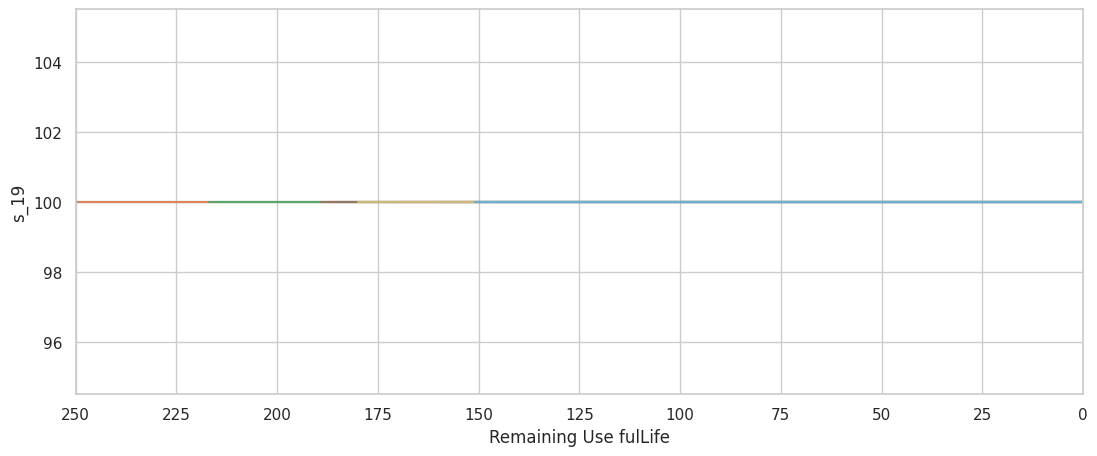

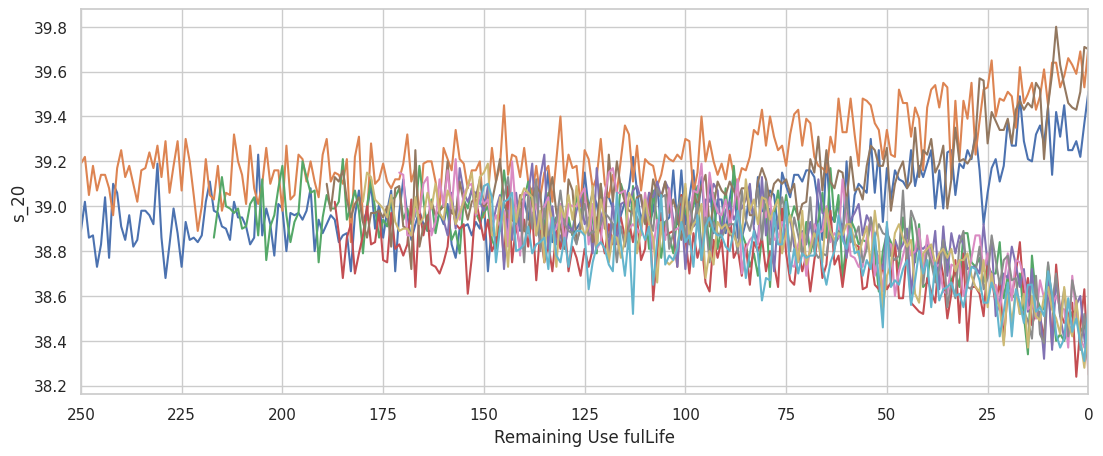

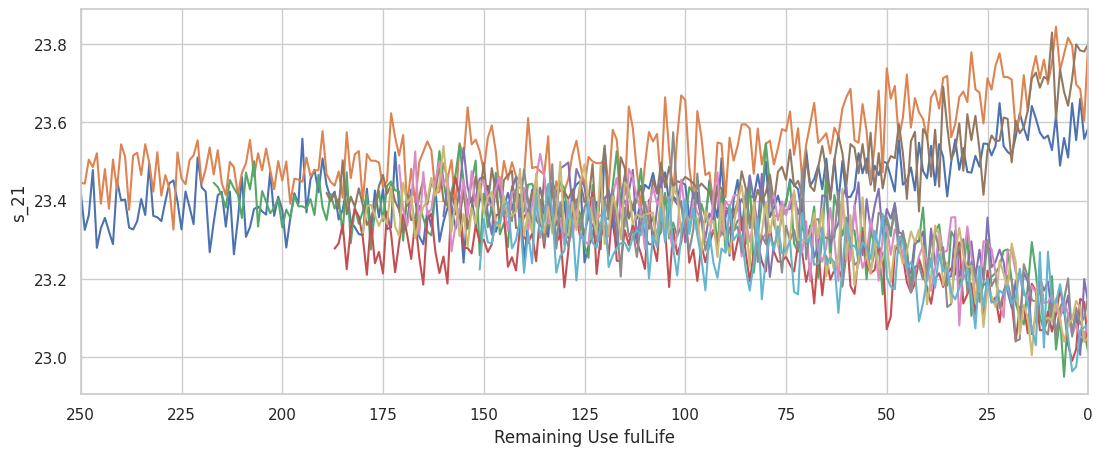

In [ ]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name,
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

Nous pouvons reconfirmer l'exclusion des capteurs 1, 5, 16, 18 et 19. Les capteurs 6 et 10 bénéficient du doute.
Notez les capteurs 7, 12, 15, 20 et 21, sur lesquels deux défauts distincts semblent visibles.

## Feature extraction


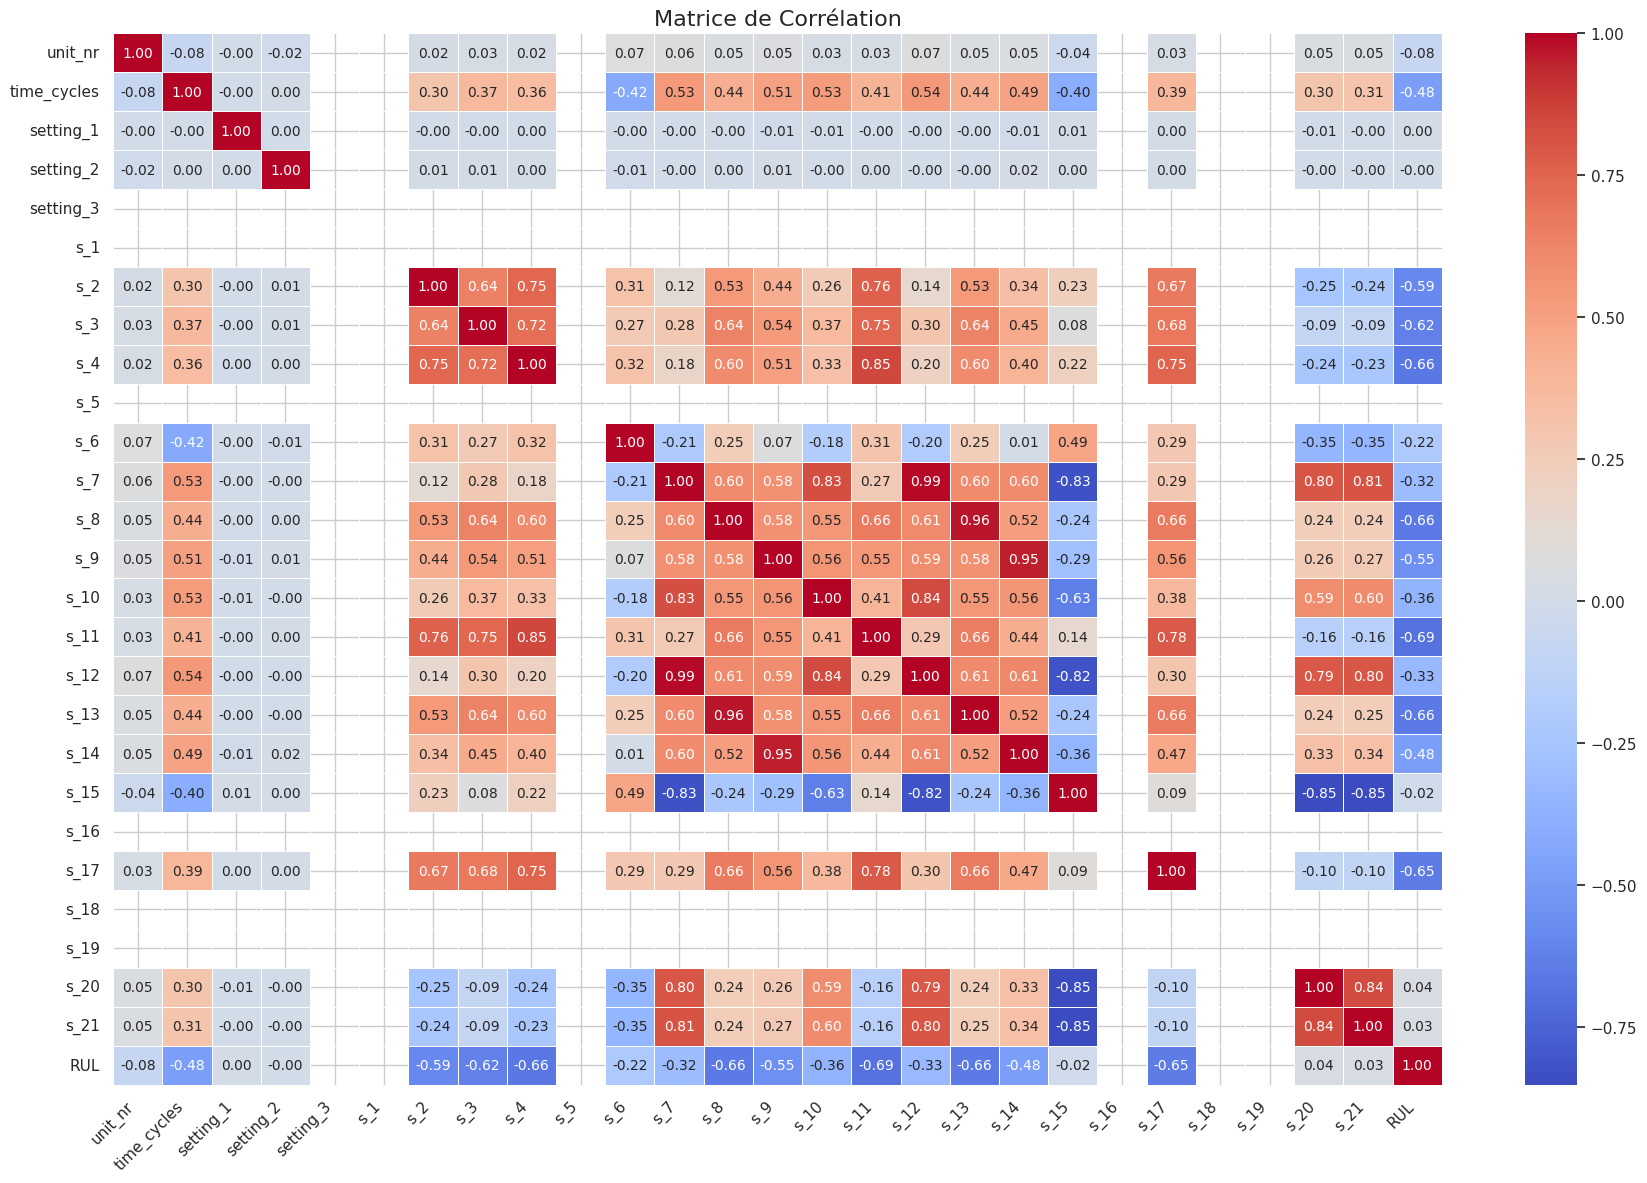

In [ ]:
def corr_matrix(data):

    plt.figure(figsize=(18, 12))  # Augmente la taille de la figure


    sns.heatmap(
        data.corr(),
        annot=True,
        fmt=".2f",  # Limite les nombres à 2 décimales
        cmap='coolwarm',
        annot_kws={"size": 10},  # Définit la taille des annotations
        linewidths=0.5  # Ajoute des séparateurs entre les cellules
    )
    plt.xticks(rotation=45, ha='right')  # Rend les labels plus lisibles
    plt.yticks(rotation=0)  # Labels y en orientation horizontale
    plt.title("Matrice de Corrélation", fontsize=16)  # Titre plus lisible
    plt.tight_layout()  # Évite les débordements
    plt.show()

# Utilisation
corr_matrix(train)


In [ ]:
# Calculer la matrice de corrélation
correlation = train.corr()

# Sélectionner les caractéristiques fortement corrélées avec 'RUL'
train_relevant_features = correlation[abs(correlation['RUL']) >= 0.3]

# Extraire uniquement la colonne pour 'RUL'
train_relevant_features['RUL']


time_cycles   -0.482744
s_2           -0.590564
s_3           -0.624236
s_4           -0.657224
s_7           -0.315048
s_8           -0.655345
s_9           -0.551843
s_10          -0.363432
s_11          -0.688915
s_12          -0.329452
s_13          -0.656340
s_14          -0.481807
s_17          -0.649220
RUL            1.000000
Name: RUL, dtype: float64

In [ ]:
# Création d'une liste contenant uniquement les caractéristiques importantes
list_relevant_features = train_relevant_features.index

list_relevant_features = list_relevant_features[1:]  # Exclut 'RUL' de la liste

# Conserver uniquement ces caractéristiques importantes dans le jeu d'entraînement
train = train[list_relevant_features]

# Séparer le jeu d'entraînement en x_train (caractéristiques) et y_train (RUL)
y_train = train['RUL']
x_train = train.drop(['RUL'], axis=1)

# Conserver uniquement les colonnes/caractéristiques de x_train dans le jeu de test
x_test = x_test[x_train.columns]

# Affichage des premières lignes de x_train
x_train.head()


s_2      s_3      s_4     s_7      s_8      s_9  s_10   s_11    s_12  \
0  642.36  1583.23  1396.84  553.97  2387.96  9062.17   1.3  47.30  522.31   
1  642.50  1584.69  1396.89  554.55  2388.00  9061.78   1.3  47.23  522.42   
2  642.18  1582.35  1405.61  554.43  2388.03  9070.23   1.3  47.22  522.03   
3  642.92  1585.61  1392.27  555.21  2388.00  9064.57   1.3  47.24  522.49   
4  641.68  1588.63  1397.65  554.74  2388.04  9076.14   1.3  47.15  522.58   

      s_13     s_14  s_17  
0  2388.01  8145.32   391  
1  2388.03  8152.85   392  
2  2388.00  8150.17   391  
3  2388.08  8146.56   392  
4  2388.03  8147.80   392

## Standardisation

In [ ]:
# Premièrement, créer une fonction d'évaluation
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse, variance

In [ ]:
# Standardisation des caractéristiques
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_trans = sc.fit_transform(x_train)
x_test_trans = sc.transform(x_test)


## Régression linéaire

train set RMSE:20.3982363092913, R2:0.7479012837465923
test set RMSE:23.80622626360563, R2:0.6692710068489904


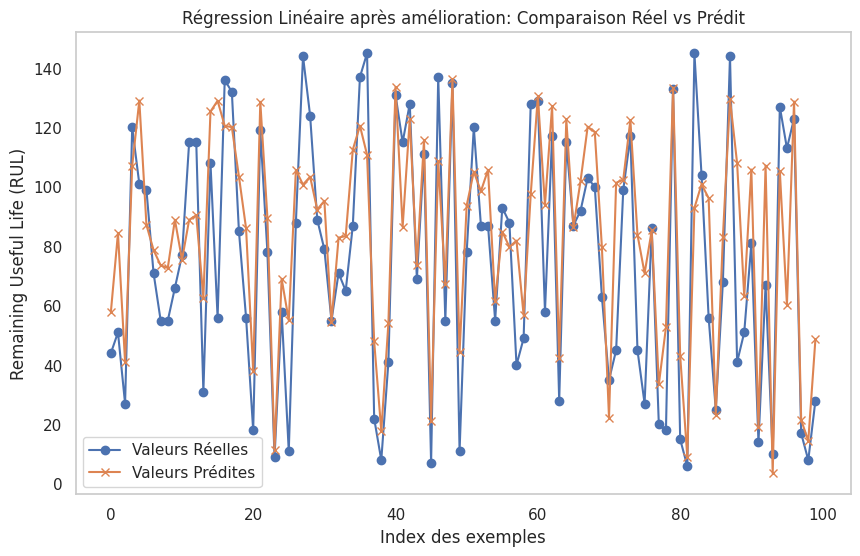

In [ ]:
# Modèle de régression linéaire clipped
from sklearn.linear_model import LinearRegression
y_train_clipped = y_train.clip(upper =125)
lm = LinearRegression()
lm.fit(x_train_trans, y_train_clipped)

# Prédire et évaluer
y_hat_train = lm.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Régression Linéaire après amélioration: Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression polynomiale

train set RMSE:16.097841134099582, R2:0.8429924014637941
test set RMSE:20.726476653929186, R2:0.7493070517338075


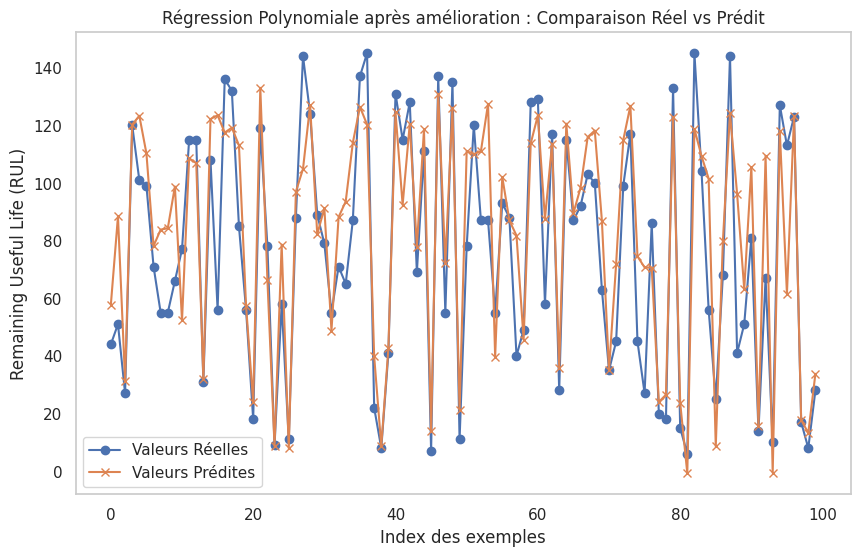

In [ ]:
# Régression polynomiale clipped
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Définir les caractéristiques polynomiales avec un degré de 4
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x_train_trans)

# Créer le modèle de régression linéaire
lin_reg_2 = LinearRegression()
lin_reg_2.fit(x_poly, y_train_clipped)

# Prédire et évaluer
y_hat_train = lin_reg_2.predict(x_poly)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lin_reg_2.predict(poly_reg.fit_transform(x_test_trans))
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Régression Polynomiale après amélioration : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression par Support Vector Machine (SVR)


In [ ]:
#feature engineering
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(x_train_trans)
X_test_transformed = poly.fit_transform(x_test_trans)

print(x_train_trans.shape)
print(X_train_transformed.shape)

(24720, 12)
(24720, 91)


In [ ]:
# SVM + clipped RUL + engineered features
# SVR
from sklearn.svm import SVR

# Création du modèle
regressor = SVR(kernel='rbf')

# Entraînement
regressor.fit(X_train_transformed, y_train_clipped)

# Prédictions et évaluation
y_hat_train = regressor.predict(X_train_transformed)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train)

y_hat_test = regressor.predict(X_test_transformed)
RMSE_Train, R2_Train = evaluate(y_test, y_hat_test)


test set RMSE:18.125956888067368, R2:0.8009384954743846
test set RMSE:24.6301867986337, R2:0.6459810040959499


In [ ]:
from sklearn.feature_selection import SelectFromModel
# Use 'linear' kernel instead of 'rbf' for feature selection
regressor_linear = SVR(kernel='linear')
regressor_linear.fit(X_train_transformed, y_train_clipped)

select_features = SelectFromModel(regressor_linear, threshold='mean', prefit=True)
select_features.get_support()

# Use get_feature_names_out() instead of get_feature_names() for scikit-learn >= 0.24
try:
    feature_names = poly.get_feature_names_out()  # For scikit-learn >= 0.24
except AttributeError:
    feature_names = poly.get_feature_names()  # For older scikit-learn versions

# Use the original DataFrame variable name (x_train)
print('Original features:\n', x_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12',
       's_13', 's_14', 's_17'],
      dtype='object')
Best features:
 ['x0' 'x2' 'x3' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x2 x7' 'x2 x8'
 'x3 x4' 'x3 x7' 'x3 x8' 'x3 x10' 'x4 x6' 'x4 x8' 'x5 x6' 'x5 x8' 'x6 x9'
 'x6 x10' 'x7 x8' 'x8^2' 'x8 x9' 'x8 x10']


(26,)

train set RMSE:17.47258815496307, R2:0.8150306044340501
test set RMSE:22.559342640194178, R2:0.703008489065529


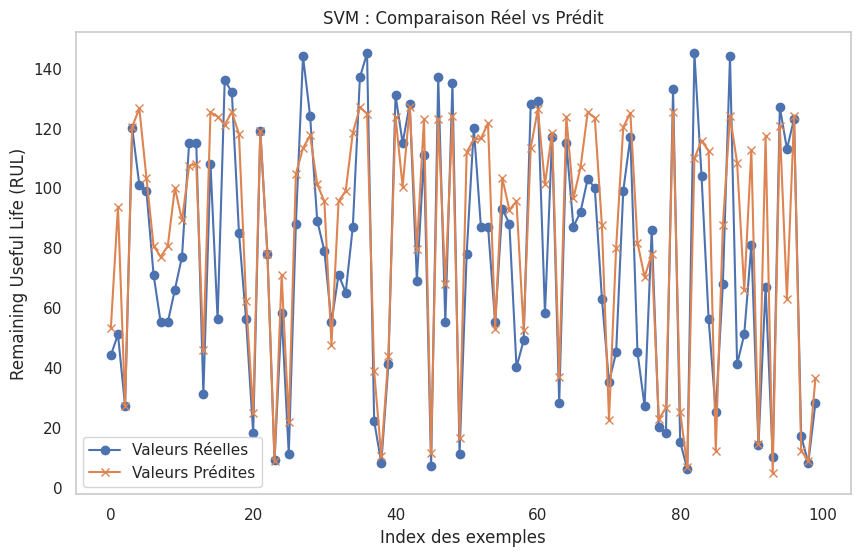

In [ ]:
# SVM regression + clipped RUL + engineered features + selection
svr = SVR(kernel='rbf')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("SVM : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('Valeur de epsilon par défaut :',svr.epsilon)

Valeur de epsilon par défaut : 0.1


In [ ]:
#Amélioration de SVR (epsilon)
epsilon = [0.4, 0.3, 0.2, 0.1, 0.05]

for e in epsilon:
    svr = SVR(kernel='rbf', epsilon=e)
    svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

    # predict and evaluate
    y_hat = svr.predict(X_train_transformed[:, select_features.get_support()])
    mse = mean_squared_error(y_train_clipped, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_train_clipped, y_hat)
    print("epsilon:", e, "RMSE:", rmse, "R2:", variance)



epsilon: 0.4 RMSE: 17.46866670382399 R2: 0.8151136221351377
epsilon: 0.3 RMSE: 17.47489267985416 R2: 0.8149818086078866
epsilon: 0.2 RMSE: 17.476281719285506 R2: 0.8149523940893377
epsilon: 0.1 RMSE: 17.47258815496307 R2: 0.8150306044340501
epsilon: 0.05 RMSE: 17.47345498340211 R2: 0.8150122510329143


##Régression par Support Vector Machine à kernel linéaire


test set RMSE:19.32882536601628, R2:0.7736417533197743
test set RMSE:25.770970349057894, R2:0.6124277293969009


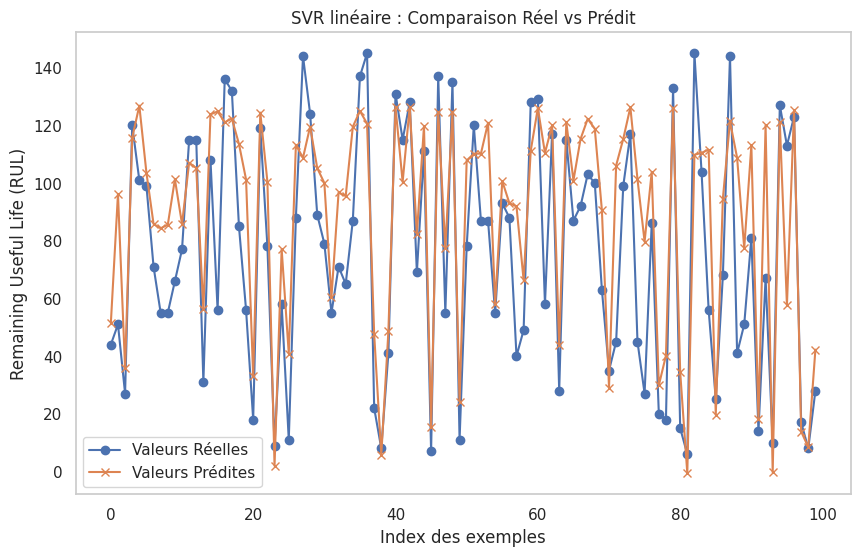

In [ ]:
# SVM lineaire + clipped RUL + engineered features
# SVR
from sklearn.svm import SVR

# Création du modèle
regressor = SVR(kernel='linear')

# Entraînement
regressor.fit(X_train_transformed, y_train_clipped)

# Prédictions et évaluation
y_hat_train = regressor.predict(X_train_transformed)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train)

y_hat_test = regressor.predict(X_test_transformed)
RMSE_Train, R2_Train = evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("SVR linéaire : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression par Decision tree


train set RMSE:13.737730940094576, R2:0.8856554658957094
test set RMSE:23.92704156165495, R2:0.6659056257471629


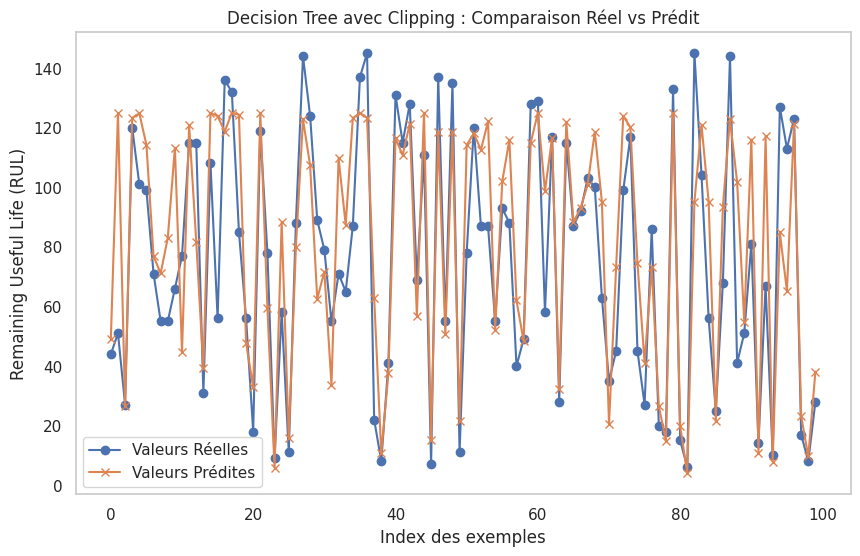

In [ ]:
# Decision Tree avec clipping
from sklearn.tree import DecisionTreeRegressor

# Appliquer le clipping sur y_train
y_train_clipped = y_train.clip(upper=125)

# Création du modèle
dt = DecisionTreeRegressor(random_state=42, max_depth=15, min_samples_leaf=10)

# Entraînement avec y_train_clipped
dt.fit(x_train_trans, y_train_clipped)

# Prédictions et évaluation sur le jeu d'entraînement
y_hat_train = dt.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

# Prédictions et évaluation sur le jeu de test
y_hat_test = dt.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Decision Tree avec Clipping : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()


## Régression par Random forest

train set RMSE:16.61288351940655, R2:0.8327849215783106
test set RMSE:22.149501680600764, R2:0.7137014987072017


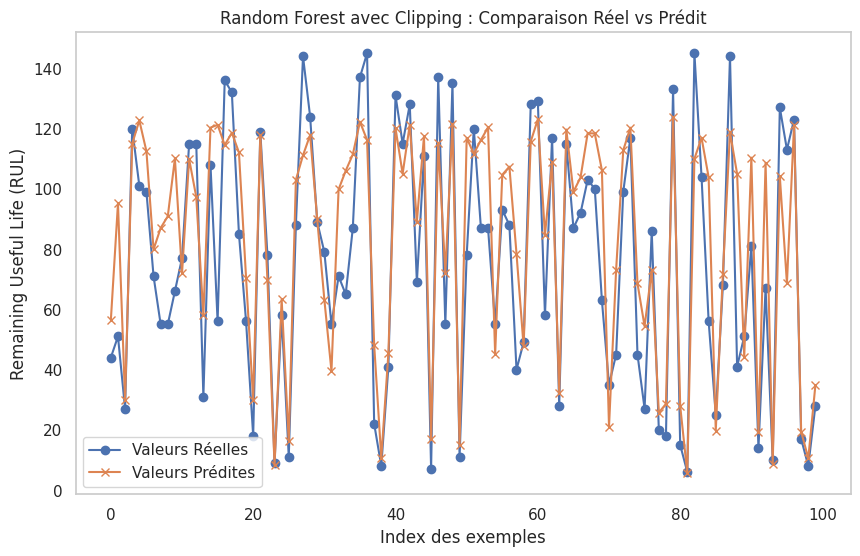

In [ ]:
# Random Forest avec clipping
from sklearn.ensemble import RandomForestRegressor

# Appliquer le clipping sur y_train
y_train_clipped = y_train.clip(upper=125)

# Création du modèle
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=6, min_samples_leaf=5)

# Entraînement avec y_train_clipped
rf.fit(x_train_trans, y_train_clipped)

# Prédictions et évaluation sur le jeu d'entraînement
y_hat_train = rf.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

# Prédictions et évaluation sur le jeu de test
y_hat_test = rf.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Random Forest avec Clipping : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()


## Artificial Neural Network (ANN)

Epoch 1/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7614.9873
Epoch 2/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 884.5613
Epoch 3/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 378.2939
Epoch 4/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 342.2275
Epoch 5/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 330.9102
Epoch 6/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 317.1786
Epoch 7/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 306.9877
Epoch 8/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 313.1019
Epoch 9/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 303.7995
Epoch 10/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 305.5698
Epoch 11/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 290.4702
Epoch 12/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 295.5386
Epoch 13/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 295.5306
Epoch 14/75
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 290.6333
Epoch 15/75
773/773 ━━━━━━━━

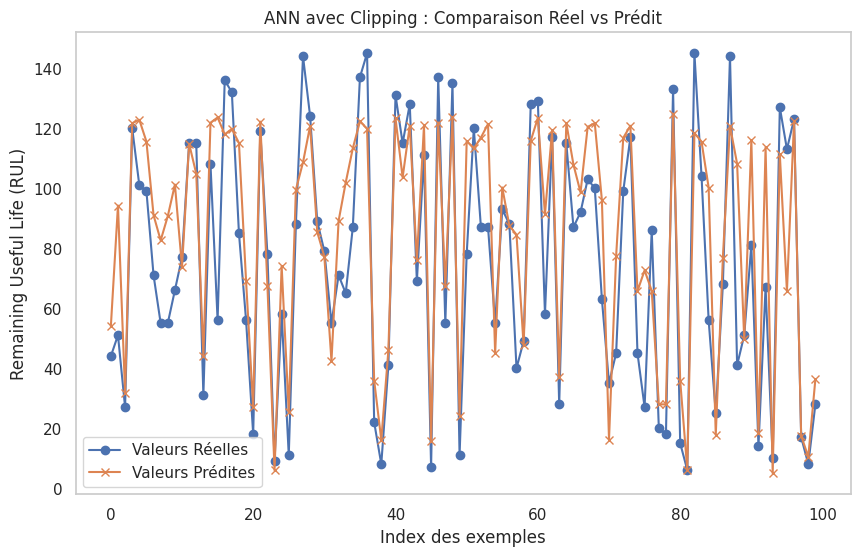

In [ ]:
# Réseau de neurones artificiels (ANN) avec clipping
import tensorflow as tf

# Appliquer le clipping sur y_train
y_train_clipped = y_train.clip(upper=125)

# Création du modèle séquentiel
ann = tf.keras.models.Sequential()

# Ajout des couches cachées avec activation ReLU
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))

# Ajout de la couche de sortie
ann.add(tf.keras.layers.Dense(units=1))

# Compilation du modèle avec l'optimiseur Adam et une fonction de perte MSE
ann.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle avec y_train_clipped
ann.fit(x_train_trans, y_train_clipped, batch_size=32, epochs=75)

# Prédictions et évaluation pour les données d'entraînement
y_hat_train = ann.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

# Prédictions et évaluation pour les données de test
y_hat_test = ann.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("ANN avec Clipping : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()


## KNN

Valeur optimale de k: 6 avec RMSE = 22.7296
train set RMSE:15.118418163993665, R2:0.8615164769243443
test set RMSE:22.729612354322672, R2:0.6985084025690875


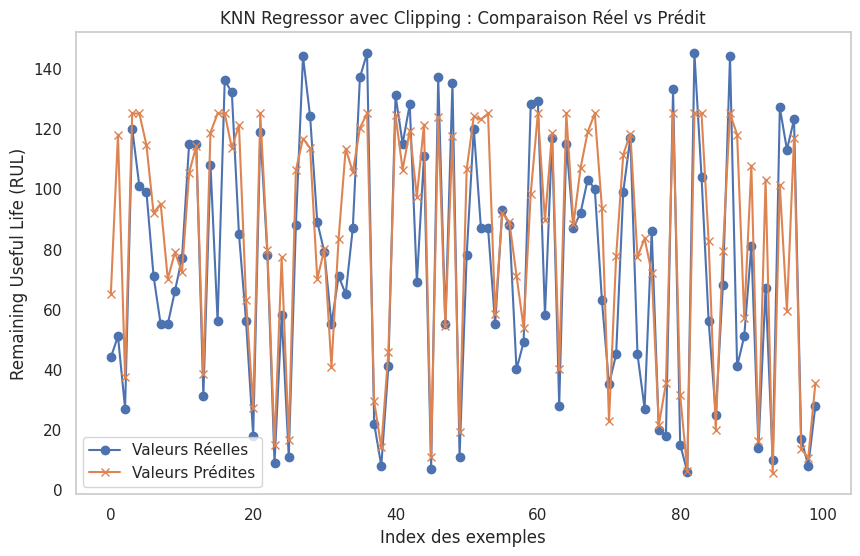

In [ ]:
# KNN Regressor avec clipping
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Appliquer le clipping sur y_train
y_train_clipped = y_train.clip(upper=125)

# Étape 1 : Choisir la valeur optimale de k
k_values = range(1, 21)  # Tester k de 1 à 20
errors = []

# Tester chaque valeur de k
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_trans, y_train_clipped)
    y_pred = knn.predict(x_test_trans)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    errors.append(rmse)

# Déterminer la valeur optimale de k
optimal_k = k_values[np.argmin(errors)]
print(f"Valeur optimale de k: {optimal_k} avec RMSE = {min(errors):.4f}")

# Étape 2 : Création du modèle avec k optimal
knn = KNeighborsRegressor(n_neighbors=optimal_k)

# Entraînement avec y_train_clipped
knn.fit(x_train_trans, y_train_clipped)

# Prédictions et évaluation pour les données d'entraînement
y_hat_train = knn.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

# Prédictions et évaluation pour les données de test
y_hat_test = knn.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("KNN Regressor avec Clipping : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()
